<a href="https://colab.research.google.com/github/aquibjaved/Deep-learning-for-text-classification/blob/master/cnn_classifier/cnn_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from gensim import models
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 3.4MB/s 


In [4]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '19vFHpNAuEUZIbOYrlXDRWJPOoXLMv3bX'
downloaded = drive.CreateFile({'id': file_id})

download = drive.CreateFile({'id': file_id})
download.GetContentFile('DOWNLOAD.tar')

# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

!unzip DOWNLOAD.tar

Archive:  DOWNLOAD.tar
   creating: Deep_learning_for_text_classification/
   creating: Deep_learning_for_text_classification/embeddings/
  inflating: Deep_learning_for_text_classification/embeddings/glove.6B.50d.txt  
   creating: __MACOSX/
   creating: __MACOSX/Deep_learning_for_text_classification/
   creating: __MACOSX/Deep_learning_for_text_classification/embeddings/
  inflating: __MACOSX/Deep_learning_for_text_classification/embeddings/._glove.6B.50d.txt  
  inflating: Deep_learning_for_text_classification/.DS_Store  
  inflating: __MACOSX/Deep_learning_for_text_classification/._.DS_Store  
   creating: Deep_learning_for_text_classification/Data/
  inflating: Deep_learning_for_text_classification/Data/imdb_master.csv  
   creating: __MACOSX/Deep_learning_for_text_classification/Data/
  inflating: __MACOSX/Deep_learning_for_text_classification/Data/._imdb_master.csv  
  inflating: Deep_learning_for_text_classification/Data/.DS_Store  
  inflating: __MACOSX/Deep_learning_for_text_c

In [5]:
embeddings_index = {}
f = open('../content/Deep_learning_for_text_classification/embeddings/glove.6B.50d.txt')
for line in f:

    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [6]:
from numpy import zeros
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [0]:
# Reading data
train_df = pd.read_csv('../content/Deep_learning_for_text_classification/Data/imdb_master.csv', encoding = "ISO-8859-1")

In [0]:
train_df = train_df.drop(["Unnamed: 0","file", "type"], axis=1)
train_df = train_df[train_df.label != 'unsup']
train_df["label"] = train_df["label"].map({"pos":1,"neg":0})

# Cleaning and Pre Processing text
import re

def clean_numbers(text):
    text = re.sub('[0-9]{5,}', '#####', text)
    text = re.sub('[0-9]{4}', '####', text)
    text = re.sub('[0-9]{3}', '###', text)
    text = re.sub('[0-9]{2}', '##', text)
    return text

def clean_text(text):
    text = clean_numbers(text)
    text = str(text)

    for punct in "/-'":
        text = text.replace(punct, ' ')
    for punct in '&':
        text = text.replace(punct, f' {punct} ')
    for punct in '?!.,"$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        text = text.replace(punct, '')

    text = text.lower()
    return text

In [9]:
# Clean text in dataFrame
train_df["processed_data"] = train_df["review"].progress_apply(lambda x: clean_text(x))
train_df["length"] = train_df["processed_data"].progress_apply(lambda x: len(x.split()))

docs = train_df["processed_data"].values
labels = train_df["label"].values

100%|██████████| 50000/50000 [00:00<00:00, 78814.26it/s]


In [10]:
# Import gc, clearing some memory in ram
import gc
del train_df
gc.collect()

21

In [0]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1


# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# pad documents to a max length of max words
max_length = 150
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
# Create Train/Test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_docs, labels, test_size=0.2, random_state=42)

In [15]:
vocab_size = vocab_size

model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], 
                                 input_length=max_length, trainable=False))

model_cnn.add(keras.layers.Conv1D(128, 5, activation='relu'))
model_cnn.add(keras.layers.MaxPool1D(5))
model_cnn.add(keras.layers.Conv1D(128, 5, activation='relu'))
model_cnn.add(keras.layers.MaxPool1D(5))

model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))

W0620 18:03:59.437712 140674955466624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 18:03:59.483527 140674955466624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 18:03:59.490568 140674955466624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 18:03:59.501940 140674955466624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0620 18:03:59.502698 1406749554

In [16]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 50)           7018250   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 128)          32128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 641       
Total para

In [18]:
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


W0620 18:05:28.216364 140674955466624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0620 18:05:28.249509 140674955466624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
history = model_cnn.fit(X_train,y_train, epochs=10, validation_data=(X_test,y_test), batch_size=256)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 6s 140us/step - loss: 0.5939 - acc: 0.6794 - val_loss: 0.5322 - val_acc: 0.7389
Epoch 2/10
40000/40000 [==============================] - 1s 34us/step - loss: 0.4600 - acc: 0.7842 - val_loss: 0.4716 - val_acc: 0.7754
Epoch 3/10
40000/40000 [==============================] - 1s 34us/step - loss: 0.3924 - acc: 0.8237 - val_loss: 0.3956 - val_acc: 0.8253
Epoch 4/10
40000/40000 [==============================] - 1s 34us/step - loss: 0.3462 - acc: 0.8481 - val_loss: 0.3821 - val_acc: 0.8287
Epoch 5/10
40000/40000 [==============================] - 1s 34us/step - loss: 0.3155 - acc: 0.8650 - val_loss: 0.3791 - val_acc: 0.8348
Epoch 6/10
40000/40000 [==============================] - 1s 35us/step - loss: 0.2708 - acc: 0.8896 - val_loss: 0.3890 - val_acc: 0.8294
Epoch 7/10
40000/40000 [==============================] - 1s 34us/step - loss: 0.2549 - acc: 0.8974 - val_loss: 0.4157 - val_ac

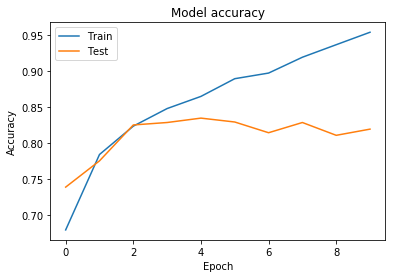

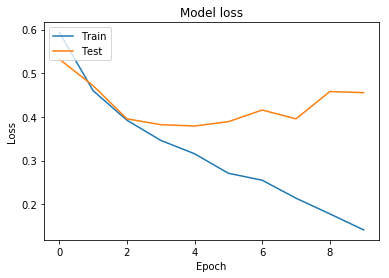

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()